In [ ]:
from SimuSamp.functions.load.SpatDat import SpatDat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#
from statsmodels.nonparametric.smoothers_lowess import lowess

# Plot CD8 Probability Distribution Relative to Tumour Boundary

In [ ]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel = 0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 12, "fontweight": "bold", "fontname": "Arial"}

## Functions

In [3]:
def get_tdist(gdf, tum_hull):
    gdf["tdist"] = gdf.geometry.distance(tum_hull)
    gdf["tdist_abs"] = gdf.geometry.distance(tum_hull.boundary)

    inside_mask = gdf["tdist"] == 0

    gdf.loc[inside_mask, "tdist"] = -gdf.loc[inside_mask, "tdist_abs"]

    gdf = gdf.drop("tdist_abs", axis=1)

    gdf = gdf.sort_values("tdist").reset_index(drop=True)

    gdf["tdist_microns"] = gdf["tdist"] * microns_per_pixel
    
    width = 50
    gdf["tdist_bin"] = [(x // width) * width for x in gdf["tdist_microns"]]

    return gdf

In [ ]:
def prob_hist(spatdat, mm2_per_pixels2=(0.22715 / 1000) ** 2):

    all_cells = spatdat.subset_cells("extended_partition")

    tum_hull = spatdat.subset_annotation("tumour_hull")

    partition = spatdat.subset_annotation("extended_partition")
    n_cells = len(all_cells)

    den = n_cells / (partition.area * mm2_per_pixels2)

    rand = spatdat.poisson_distribution("extended_partition")

    rand_dist = get_tdist(rand, tum_hull)

    areas = rand_dist["tdist_bin"].value_counts() / den
    rand_dist["area"] = rand_dist["tdist_bin"].map(areas)

    cell_dist = get_tdist(all_cells, tum_hull)


    # Merge areas and cell counts
    cell_counts = cell_dist["tdist_bin"].value_counts().reset_index()
    cell_counts = cell_counts.merge(rand_dist[["tdist_bin", "area"]], on="tdist_bin", how="left")
    cell_counts = cell_counts.drop_duplicates().reset_index(drop=True)

    cell_counts["den"] = (cell_counts["count"]) / (cell_counts["area"])

    cell_counts["prob"] = (cell_counts["count"] / cell_counts["count"].sum()) / (cell_counts["area"] / cell_counts["area"].sum())

    # Normalize probabilities
    cell_counts["prob"] = cell_counts["prob"] / cell_counts["prob"].sum()

    # Smooth Probabilities
    lowess_result = lowess(cell_counts["prob"], cell_counts["tdist_bin"], frac=0.2)

    cell_counts["smoothed_prob"] = np.interp(cell_counts["tdist_bin"], lowess_result[:, 0], lowess_result[:, 1])

    cell_counts = cell_counts.sort_values("tdist_bin").reset_index(drop=True)

    return cell_counts

## Get Probability Histogram for Each Specimen

In [ ]:
hist_list = []
for sampleid in sampleids:
    spatdat = SpatDat(sampleid=sampleid, parent_filepath=parent_filepath)

    hist = prob_hist(spatdat)

    hist["sampleid"] = sampleid

    # Exclude bins with low area
    hist = hist[hist["area"] > 0.1]

    hist_list.append(hist)

    plt.plot(hist["tdist_bin"], hist["smoothed_prob"])
    plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
    plt.ylabel("Probability", fontdict=font_dict)

    plt.yticks(fontname="Arial", fontweight="bold")

    xticks = np.arange((min(hist["tdist_bin"]) // 1000) * 1000, ((max(hist["tdist_bin"]) + 2000) // 1000) * 1000, 1000)
    
    plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")
    
    plt.gca().tick_params(width=2)

    plt.gca().spines["left"].set_linewidth(2)
    plt.gca().spines["bottom"].set_linewidth(2)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.axvline(0, color="red", linewidth=2)

    plt.savefig(f"../../../../Data/Plots/ProbHist/{sampleid}_prob_hist_smoothed.png", dpi=600)

    plt.cla()
    plt.clf()

    plt.plot(hist["tdist_bin"], hist["den"])
    plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
    plt.ylabel("Density (cells/mm\u00b2)", fontdict=font_dict)

    plt.yticks(fontname="Arial", fontweight="bold")
    
    xticks = np.arange((min(hist["tdist_bin"]) // 1000) * 1000, ((max(hist["tdist_bin"]) + 2000) // 1000) * 1000, 1000)
    
    plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

    plt.gca().spines["left"].set_linewidth(2)
    plt.gca().spines["bottom"].set_linewidth(2)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.axvline(0, color="red", linewidth=2)

    plt.savefig(f"../../../../Data/Plots/DenHist/{sampleid}_den_hist.png", dpi=600)

    plt.cla()
    plt.clf()

cohort_hist = pd.concat(hist_list)
cohort_hist.to_excel("../../../../Data/cohort_hist_data.xlsx", index=False)

<Figure size 640x480 with 0 Axes>

# Get Probability Distribution for Overall Cohort

In [60]:
# Overall Cohort
cohort_hist = pd.read_excel("../../../../Data/cohort_hist_data.xlsx")

cohort_total = cohort_hist.groupby("tdist_bin").sum()[["count", "area"]].reset_index()
cohort_total["den"] = cohort_total["count"] / cohort_total["area"]
cohort_total["prob"] = cohort_total["count"] / cohort_total["count"].sum() / (cohort_total["area"] / cohort_total["area"].sum())
cohort_total["prob"] = cohort_total["prob"] / cohort_total["prob"].sum()

lowess_result = lowess(cohort_total["prob"], cohort_total["tdist_bin"], frac=0.2)
cohort_total["smoothed_prob"] = np.interp(cohort_total["tdist_bin"], lowess_result[:, 0], lowess_result[:, 1])

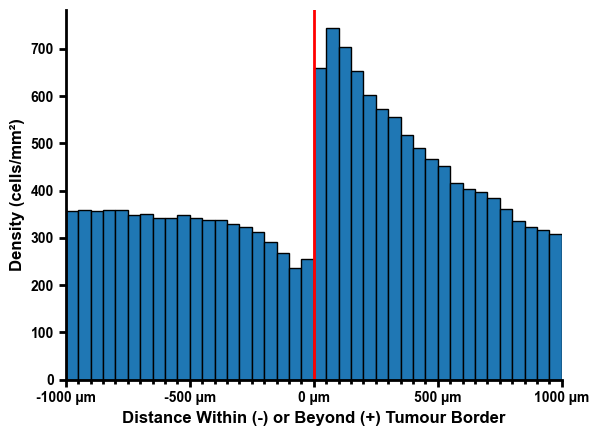

In [62]:
intratum_mean = cohort_total[cohort_total["tdist_bin"] < 0]["den"].mean()
intratum_std = cohort_total[cohort_total["tdist_bin"] < 0]["den"].std()

plt.bar(cohort_total["tdist_bin"], cohort_total["den"], width=50, edgecolor="black", align="edge")
plt.xlabel("Distance Within (-) or Beyond (+) Tumour Border", fontdict=font_dict)
plt.ylabel("Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(fontname="Arial", fontweight="bold")

xticks = np.arange((min(cohort_total["tdist_bin"]) // 500) * 500, ((max(cohort_total["tdist_bin"]) + 1000) // 500) * 500, 500)

plt.xticks(xticks, labels=[f"{int(tick)} \u00B5m" for tick in xticks], fontname="Arial", fontweight="bold")

plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50))
plt.gca().tick_params(which="minor", width=2, length=3)

plt.gca().tick_params(width=2, length=5)

plt.xlim(-1000, 1000)

# plt.ylim(-2.5, 6)

plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.axvline(0, color="red", linewidth=2)

# plt.savefig(f"../../../../Data/Plots/ProbHist/total_prob_hist_cropped.png", dpi=600)